# **Deep Learning Project**

Moro Mattia
The Notebook will implement an algorithm of sentimen analysis to predict the rating of the Park based on the review and other features. This project was created as exam of the 'Deep learning' module from the 'Machine Learning and Deep learning' course, successfully passed with evaluation 29/30 (30/30 in the total exam, considering also Machine Learning).

In [ ]:
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import LSTM, Embedding
from keras.layers.core import Dense, Activation
import tensorflow as tf
import pandas as pd
import requests
import zipfile
import io
import urllib

## **1) From the raw data to the input(s)**

This was the first request (how to design the input layer). However, before that, it is necessarily to cover some adequate preprocessing steps.

First of all, we import the dataset from GitHub (the file was zipped because too big).

In [ ]:
url = 'https://github.com/MoroMattia02/DL_exam/raw/main/parkReviews.zip'
response = requests.get(url)
zip_file = io.BytesIO(response.content)


with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    csv_filename = zip_ref.namelist()[0]
    zip_ref.extractall('/content/')

df_pre = pd.read_csv(f'/content/{csv_filename}',on_bad_lines='skip',encoding='latin-1')

The dataset contains approximately 42000 reviews with 5400000 total words and 87000 unique ones. These numbers can't clearly be handled from this simple colab notebook. For this reason, only a subset of the dataset was taken.
Before the sampling, i applied another filter. I reflected on the fact that, if i'm forced to take a subset of the dataset, and the most informative column has as mean approximately 130, the best choice was to first filter out 'outliers'. In fact, before sampling i created a function 'count_words' (is approximately correcrt, the real function for counting valid words is defined below, but it was too heavy to compute on 5400000 items), thanks to which i created a column with the number of words for each review. Then i took only reviews with words from 150 to 170, by predicting a loss of words of more or less 30 without punctuation and other non valid tokens.
Then, for the sampling, after trying to run the network with different numbers of samples, 700 was the most reasonable trade-off between computational complexity and (still low) performance. In conclusion, a random sample (without replacement obviously) of 700 elements was taken.

In [ ]:
def count_words(text):
    words = text.split()  # splits the text at space
    return len(words)

df_pre['word_count'] = df_pre['Review_Text'].apply(lambda x: count_words(x)) #apply to the column


df_pres = df_pre.loc[(df_pre['word_count'] >= 150) & (df_pre['word_count'] <= 170)] #filter for number of words
df = df_pres.sample(450, replace=False,random_state=1) #sampling

Now that the dataset is less heavy i can create the function to get the real words, and then filter the colum of reviews. To be precise, i repeat the counting process after the filtering.

In [ ]:
import string
def get_words(text):
  text = text.replace('--', ' ')
  # split into tokens by white space
  words = text.split()
  # remove punctuation from each token
  table = str.maketrans('', '', string.punctuation)
  words = [w.translate(table) for w in words]
  # remove remaining tokens that are not alphabetic
  words = [word for word in words if word.isalpha()]
  # make lower case
  words = [word.lower() for word in words]
  return words

def filter_words(df, text_column, unique_word_list):
    filtered_column = df[text_column].apply(lambda text: ' '.join(word for word in text.split() if word in unique_word_list))
    df[text_column] = filtered_column
    return df

text = df['Review_Text'].str.cat(sep = " ")
prt = get_words(text)
unique_words = np.unique(prt)

df_valid = filter_words(df, 'Review_Text', unique_words)
df_valid

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,word_count
32236,474897517,5,2016-11,Ireland,visit every last year for my birthday as was a...,Disneyland_Paris,169
17940,302685040,5,2015-8,United States,for pete know what getting into when you go bu...,Disneyland_California,165
21184,225785637,5,2014-8,Canada,the prrice keeps going up but how can you not ...,Disneyland_California,156
20356,241984006,4,2014-11,Canada,time being to the the racing was very fun and ...,Disneyland_California,155
38404,201442095,1,missing,United Kingdom,loads of others rides kept closing for the mid...,Disneyland_Paris,153
...,...,...,...,...,...,...,...
42259,58409261,1,missing,United Kingdom,had a great time midweek untill my year old da...,Disneyland_Paris,155
31270,531328489,3,missing,Ireland,from to but the park was too busy at the the g...,Disneyland_Paris,151
22844,188966355,4,2013-12,United States,have been to many but every time we it seems t...,Disneyland_California,156
12068,528081243,4,2017-9,United States,the two parks for a total of during the celebr...,Disneyland_California,160


In [ ]:
df_valid.drop(['word_count'], axis=1)
df_valid['word_count'] = df_valid['Review_Text'].apply(lambda x: count_words(x))

Now we can print mean and standard deviation of the number of words.

In [ ]:
df_valid['word_count'].std()

10.452813808052614

In [ ]:
df_valid['word_count'].mean()

124.33555555555556

As we can see, the sample mean is not too far from the population mean.

### **Word Embeddings**

The most accurate choice for word embedding would have been to train a word2vec on our own dictionary and then use that, or maybe to download the one from google. However, to remain adherent to what was seen in the course, i embedded the words as one-hot vectors.
These are the steps that i followed:

- get all the unique words (already done above in the code);
- create a dictionary {word:index};
- replace any index with the correspondent one-hot vector, using as length the number of unique words and placing the 1 at the position given by the dictionary;

These are the steps to create the dictionary {word:vector}.



In [ ]:

unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print(len(unique_words))
print(f"Unique words:{unique_words[:20]}")
print(list(unique_word_index.items())[:20])

5466
Unique words:['a' 'aa' 'aaa' 'abandoned' 'ability' 'abit' 'able' 'about' 'above'
 'abruptly' 'absent' 'absolute' 'absolutely' 'abt' 'abuse' 'abysmal' 'ac'
 'accent' 'accept' 'acceptable']
[('a', 0), ('aa', 1), ('aaa', 2), ('abandoned', 3), ('ability', 4), ('abit', 5), ('able', 6), ('about', 7), ('above', 8), ('abruptly', 9), ('absent', 10), ('absolute', 11), ('absolutely', 12), ('abt', 13), ('abuse', 14), ('abysmal', 15), ('ac', 16), ('accent', 17), ('accept', 18), ('acceptable', 19)]


In [ ]:
print(unique_word_index)

{'a': 0, 'aa': 1, 'aaa': 2, 'abandoned': 3, 'ability': 4, 'abit': 5, 'able': 6, 'about': 7, 'above': 8, 'abruptly': 9, 'absent': 10, 'absolute': 11, 'absolutely': 12, 'abt': 13, 'abuse': 14, 'abysmal': 15, 'ac': 16, 'accent': 17, 'accept': 18, 'acceptable': 19, 'accepting': 20, 'access': 21, 'accessed': 22, 'accessible': 23, 'accident': 24, 'accommodate': 25, 'accommodated': 26, 'accommodating': 27, 'accommodation': 28, 'accomodation': 29, 'accomodations': 30, 'accompany': 31, 'accompanying': 32, 'accomplished': 33, 'according': 34, 'accordingly': 35, 'accounts': 36, 'accurate': 37, 'accustomed': 38, 'acknowledged': 39, 'across': 40, 'act': 41, 'acting': 42, 'actionget': 43, 'activities': 44, 'activity': 45, 'actor': 46, 'actors': 47, 'actual': 48, 'actually': 49, 'actuallyspace': 50, 'adc': 51, 'add': 52, 'added': 53, 'addition': 54, 'additional': 55, 'address': 56, 'addressing': 57, 'adds': 58, 'adequate': 59, 'adequately': 60, 'adjust': 61, 'admission': 62, 'admissions': 63, 'admit'

In [ ]:
from keras.utils import to_categorical
updated_word_index = {word: to_categorical(index, num_classes=len(unique_word_index),dtype='float64') for word, index in unique_word_index.items()}

In [ ]:
print(list(updated_word_index.items())[:3])

[('a', array([1., 0., 0., ..., 0., 0., 0.])), ('aa', array([0., 1., 0., ..., 0., 0., 0.])), ('aaa', array([0., 0., 1., ..., 0., 0., 0.]))]


Now i convert the words in the reviews in a numpy array. In doing this i used a function that:

- defines the dimensions of the array (num_words x num_features), notice that num_features is the embedding dimension;

- fills each row (correspondent to the word) of the array with the right vector, by comparing the word from the review with the dictionary.

Because the mean of words per review in the exam text was said to be 130, i decided to put the num_words to 130 for each review. In this way the reviews with less than 130 words will be filled with zero vectors, and the ones with more will be cut at 130. This could not be the more efficient solution, but it was the most accurate because the network requires a tensor which has a not ambigous shape.

In [ ]:
def convert_to_one_hot(filtered_words, word_vector_dict):
    num_words = len(filtered_words)
    num_features = len(next(iter(word_vector_dict.values())))
    one_hot_vectors = np.zeros((num_words, num_features)) #zeros array

    for i, word in enumerate(filtered_words): #fill the array
        if word in word_vector_dict:
            one_hot_vectors[i] = word_vector_dict[word]

    return one_hot_vectors

# Apply the conversion function to the 'Review_Text' column
df_valid['Review_Text'] = df_valid['Review_Text'].apply(lambda x: x[:130]) #all reviews max 130 words
df_valid['One_hot'] = df_valid['Review_Text'].apply(lambda x: convert_to_one_hot(x, updated_word_index))

Then, i create a column dor the one hot vectors. Here is the actual dataset:

In [ ]:
df_valid.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,word_count,One_hot
32236,474897517,5,2016-11,Ireland,visit every last year for my birthday as was a...,Disneyland_Paris,144,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
17940,302685040,5,2015-8,United States,for pete know what getting into when you go bu...,Disneyland_California,105,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
21184,225785637,5,2014-8,Canada,the prrice keeps going up but how can you not ...,Disneyland_California,120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
20356,241984006,4,2014-11,Canada,time being to the the racing was very fun and ...,Disneyland_California,118,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
38404,201442095,1,missing,United Kingdom,loads of others rides kept closing for the mid...,Disneyland_Paris,116,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


As said, each review is an array num_words x embedding_dimension

In [ ]:
for i in df['One_hot']:
  print(i.shape)

(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130, 5466)
(130

At this point we have the embedding, so the column with the raw text is no more useful!

In [ ]:
df_valid = df_valid.drop(['Review_Text'], axis=1)

In [ ]:
df_valid.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Branch,word_count,One_hot
32236,474897517,5,2016-11,Ireland,Disneyland_Paris,144,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
17940,302685040,5,2015-8,United States,Disneyland_California,105,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
21184,225785637,5,2014-8,Canada,Disneyland_California,120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
20356,241984006,4,2014-11,Canada,Disneyland_California,118,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
38404,201442095,1,missing,United Kingdom,Disneyland_Paris,116,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


This is the look of the dataset with the embedding done on the reviews. However, as i said in the written part, i will use also the other features (if i have informations i generally prefer to not throw them away, even tought i recognize that the crucial role is played by the reviews).

### **Data Preprocessing**
For the other features, this is the setting

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer


First of all, i split the 'Year_Month' column in one 'Year' and one 'Month' column, in order to allow keras to process the data. For the same reason, after i will also convert the values in the format 'Int64', from 'object'.

In [ ]:
df_valid[['Year', 'Month']] = df_valid['Year_Month'].str.split('-', expand=True)
df_valid = df_valid.drop(['Year_Month'], axis=1)
df_valid.head()

,Review_ID,Rating,Reviewer_Location,Branch,word_count,One_hot,Year,Month
32236,474897517,5,Ireland,Disneyland_Paris,144,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2016,11
17940,302685040,5,United States,Disneyland_California,105,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2015,8
21184,225785637,5,Canada,Disneyland_California,120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2014,8
20356,241984006,4,Canada,Disneyland_California,118,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2014,11
38404,201442095,1,United Kingdom,Disneyland_Paris,116,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",missing,None


An important point is that some of the reviews are not providing full information about the data. This because maybe there was the year and not the month, or viceversa, or both. The point is that after the splitting of Y-M some missing values arise, as we can see below. This will be taken into account in the processing steps done after.

In [ ]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 32236 to 22598
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          450 non-null    int64 
 1   Rating             450 non-null    int64 
 2   Reviewer_Location  450 non-null    object
 3   Branch             450 non-null    object
 4   word_count         450 non-null    int64 
 5   One_hot            450 non-null    object
 6   Year               450 non-null    object
 7   Month              418 non-null    object
dtypes: int64(3), object(5)
memory usage: 31.6+ KB


Here is the most important part of the features preprocessing (apart from the text part). I will apply the following trasformations to the columns:

- Location: first of all, i applied the one-hot encoding in the classical sklearn way, then, because there were too many unique locations, i reduced the dimensionality with the TruncatedSVD (i couldn't use the PCA as i said in the written part because the input was sparse);

- Branch: because there were just two branches, the one-hot encoding was enough in this case;

- Year and Month: for these two columns first of all i applied an imputer to fill missing values, in fact by applying the convertion to Int64 some other missing values arise. Then i scaled them with standard scaler. This step can be very important to improve the model overall stability during training.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
pip = Pipeline([
    ('imp', KNNImputer()),
    ('scaler', StandardScaler() ),
])

pipl = Pipeline([
    ('encoder', OneHotEncoder()),
    ('dim', TruncatedSVD(n_components=20)),
])

column_transformer = ColumnTransformer(transformers=[
    ('pip_l', pipl, ['Reviewer_Location']),
    ('encoder', OneHotEncoder(), ['Branch']),
    ('imp_scal', pip, ['Year', 'Month'])],  # Specify the transformer and the column(s) to apply it on
    remainder='passthrough',verbose_feature_names_out=False)  # Pass through any remaining columns as is

columns_to_convert = ['Year', 'Month']
df_valid[columns_to_convert] = df_valid[columns_to_convert].apply(pd.to_numeric, errors='coerce').astype(pd.Int64Dtype())


## **The Model**

In this section there is the most important part of the project, so the creation of the model. First of all i split the dataset between training and test set, with an 80% of instances in the first. I also put some random state and split in base of the proportion of y (with stratify). Before splitting, i remove the word_count column, as it's no more useful.

In [ ]:
from sklearn.model_selection import train_test_split

X = df_valid.drop(['Rating','word_count'], axis=1)
y = df_valid['Rating']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=101, stratify=y)

Notice, the pipeline isn't applied yet, so we still have the datas as before.

In [ ]:
X_train

,Review_ID,Reviewer_Location,Branch,One_hot,Year,Month
3144,437701069,Macau,Disneyland_HongKong,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2015,12
35393,307281324,United Kingdom,Disneyland_Paris,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2015,8
7487,188079803,South Africa,Disneyland_HongKong,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2013,12
29373,643311010,United Kingdom,Disneyland_Paris,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2018,12
4459,360407585,United Kingdom,Disneyland_HongKong,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2016,3
...,...,...,...,...,...,...
28838,10073111,Australia,Disneyland_California,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",<NA>,<NA>
31270,531328489,Ireland,Disneyland_Paris,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",<NA>,<NA>
3280,428989422,United States,Disneyland_HongKong,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2016,8
40373,146001483,United Kingdom,Disneyland_Paris,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2012,11


### **Adaptation of the training set**

As i described in the test, the model consists in:

- an RNN which processes the single reviews with 130 time steps and produces a compact representation of each review text;

- an MLP that takes as input the concatenation between the compact representation produced from the RNN and the remaining features.

This means that the model takes two different inputs in two differen moments!
It is possible to do so, but i had to split the dataset in:

- one part with only the embedding column 'One_Hot';
- another part with all the other features.

This is done here:

In [ ]:
X_train_features = X_train.drop(['One_hot'], axis=1)
X_train_reviews = X_train['One_hot']
X_test_features = X_test.drop(['One_hot'], axis=1)
X_test_reviews = X_test['One_hot']

Now i process the part of the features, simply by applying the column transformer defined above and then converting everything into a tensor, to be used from the model. At the end i have a 560 x 26 tensor for the MLP.

In [ ]:
X_train_fearues_def = column_transformer.fit_transform(X_train_features)
X_train_fearues_def_t = tf.convert_to_tensor(X_train_fearues_def)
X_test_fearues_def = column_transformer.fit_transform(X_test_features)
X_test_fearues_def_t = tf.convert_to_tensor(X_test_fearues_def)

For what regards the embedding column, the situation is different.
First, i had to convert the pd.series object (the column) into a list, in order to be able to access the single items (the reviews). This was done in order to transform the column in an array with dimension 560 x 130 x 6967 with np.reshape, and then into a tensor with the same dimensions. In this way the data can be used as input for the RNN.

In [ ]:
num_words, encoding_dim = X_train_reviews.iloc[0].shape
X_train_reviews = X_train_reviews.tolist()
X_train_reviews_array = np.reshape(X_train_reviews, (len(X_train), num_words, encoding_dim))
X_train_reviews_tensor = tf.convert_to_tensor(X_train_reviews_array)
X_test_reviews = X_test_reviews.tolist()
X_test_reviews_array = np.reshape(X_test_reviews, (len(X_test), num_words, encoding_dim))
X_test_reviews_tensor = tf.convert_to_tensor(X_test_reviews_array)

In [ ]:
X_train_reviews_tensor.shape

TensorShape([360, 130, 5466])

The target column has to firstly be subtracted by 1, in order to match with the positions of the output layer. Then i get the num_classes for later.

In [ ]:
y_traindef = y_train.apply(lambda x: x - 1)
y_traindef.unique()
num_classes = len(y_traindef.unique())
y_train_dense = tf.convert_to_tensor(y_traindef)
y_testdef = y_test.apply(lambda x: x - 1)
y_testdef.unique()
num_classes = len(y_testdef.unique())
y_test_dense = tf.convert_to_tensor(y_testdef)

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Bidirectional, GRU

## **The Network**

The first part of the network is the recurrent. I define an input layer with shape (nwords,encode_dim). This means that then the recurrent layer will have exactly nwords time steps, and in each one it will analyze a vector of length encoding_dim.

The recurrent layer i used was a Bidirectional, this because ideally, in textual data, at time step t, both previous and next words can be useful as informations. The Bidirectional took then the GRU. With an already heavy model, using GRU instead of a classical LSTM allowed for a sliglt decreasing number of computations and space.

In [ ]:
text_input = Input(shape=(num_words, encoding_dim), name='text_input')
cr = Bidirectional(GRU(128))(text_input)

Then, another input layer is defined for the other features. This input layer has 'num_features' dimensions (feature_shape), that is 26 , after the application of column transformer. This means that the MLP later will analyze each sample of 26 features out of the 560 samples for the training.

In [ ]:
feature_shape = X_train_fearues_def_t.shape[1]
feature_inputs = Input(shape=(feature_shape), name='feature_inputs')

Now that i have the output of the Recurrent 'cr' and the 'feature_inputs', i can concatenate them. This means that, by having my 'cr' of dimension 128 and the 'feature_inputs' of dimension 26, the MLP will take as input for each sample a 128+26 dimension vector.

Then, there is the MLP. I precise that later there will be a dedicated section for the choice of each network parameter.

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from keras.layers.regularization.dropout import Dropout
from tensorflow.keras import layers
from tensorflow.keras import regularizers
# Concatenate the LSTM output with the other inputs
concat = Concatenate()([cr, feature_inputs])

# Define the MLP layers
l1 = Dense(256, activation='sigmoid',kernel_initializer='glorot_normal')(concat)
ld = Dropout(0.2)(l1)
l2 = Dense(128, activation='swish',kernel_initializer='he_normal')(l1)
l3 = Dense(64, activation='sigmoid',kernel_initializer='glorot_normal')(l2)
output = Dense(num_classes, activation='softmax')(l3)

Now the creation of the model. I create the model and pass to it a list of tensors instead of only one. This will allow for using each one in different moments (one before for the recurrent and the other later on in the MLP). As output of the model i take the output layer defined above after the MLP. According to what said in the exam, the output layer has num_classes neurons (5) and uses a softmax activation, so that the output is a vector with the probabilities of belonging to each class. (section 2 of the exam)

Then, the loss i used was the SCCE, because we have continous class labels to predict. (part of section 5 of the exam)

In [ ]:
from keras.optimizers import SGD, Adam
from sklearn.utils import compute_class_weight

model = Model(inputs=[text_input, feature_inputs], outputs=output)

## **Hyperparameters and evaluation**


Until now i examined only the 'fixed' choiches, while in this section i will examine all the hyperparameters described in the written exam. This part corresponds to the requests 3-4-5-6 of the exam.
As said in the exam, i took on a mininmalist approach. Initially the model had only the LSTM layer and a simple 3-layers MLP (output layer included). Then, as other hyperparameters i only used a 32 batch size and 30 epochs. At the actual state, here are the parameters and the reasons i choose them:

- Bidirectional(GRU): i choosed this because of the reason previously indicated;
- dimension of recurrent state (128): I started with a smaller value, then i saw that the performance was slighly increasing by increasing this dimension;
- MLP: initially it had only 2 layers (output excluded) with few neurons. I verified that the network was benefitting from a little deep (3 dense layers before the output one) and expecially from an increased number of neurons (initally only 64, now the biggest layer has 256 of them, and the number decreases until 64 in the last layer). The activations in the MLP are most of all Sigmoids. In the written part i stated that Relu or Swish were better, but not in this extreme case. In fact, after all the processing, the input of the MLP is quite sparse (contains a lot of 0), so the problem of the dying Relu actually occured. For this reason i used sigmoid activations in the first and last layers, and swish in the second (if used only here, the performance wasn't affected). Then, the corresponding initializers were used, as said in the exam (GlorotNormal for Sigmoid and HeNormal for Swish).

For the other parameters:

- optimizer: i tried both Adam and SGD, and the first was, as predicted, better, and had also a faster training;
- learning rate: initially i tried a small one (0.0001) and then tried bigger ones, but the best performance was obtained with a decaying one (in particular exponential schedule with the parameters above);
- metrics: this choice was quite forced, in the case of multiclass classification the accuracy is the most informative one;
- epochs: initially 30, but in all the cases i tried i saw a sort of plateau after 20 of them, so i left the value at 20 to not waste resources;
- batch size: initially  i tought that a smaller batch size would be better, but by trying differenf of them i verified that a bigger one was improving the performances (and also speeding up the training).

Then, by testing the model, i added two more things:

- Dropout: i added a dropout(0.02) layer after the first dense;
- Imbalance classes: i saw that the majority of the reviews had 5 stars. In fact, initially the loss was stacked in a local minima, assigning 5 stars to each review and reaching a low loss but with a not compatible performance (this was the major factor that made me think about this issue). I couldn't handle this with an oversmapling method, because the model has too many features, and also with an unsampling one, because there are already few training instances. The only reasonable solution i found was to assign a weight to each class. In this way the performance decreased a lot, but at least the model wasn't unbalanced anymore. I also reflected on the fact that, maybe, if the majority of the reviews have 5/5, maybe it was due to the fact that the park was particularly appreciated, so this sort of 'bias' wasn't cursing the model, but then i preferred to add the weights because in an ideal setting this would guarantee better generalization for other park reviews (that maybe aren't that great).

Here below we can see the situation graphically, for the target vector y_train

<Axes: ylabel='Frequency'>

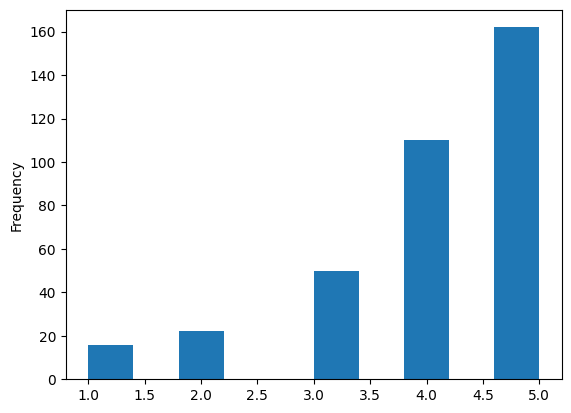

In [ ]:
y_train.plot.hist()

### **Discarded Choices**

Also other parameters were tested, but then neglected for some reasons, here are them:

- Batch Normalization: i tried it in some positions between the layers, but in every case it killed the performance;

- Relu as activation: a little explained above, but shortly because of the sparsity there was dying Relu;

- weight regularization: just tested with and without, the performance was quite the same, so i didn't used them to save space;


Here below there are such the parameters involved in the .compile and .fit method. The ones involving layers are above and displayed in the summary below

In [ ]:
classWeight = compute_class_weight('balanced', classes=np.unique(y_traindef), y=y_traindef)
classWeight = dict(enumerate(classWeight))
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.66,
    staircase=True)
model.compile(optimizer=Adam(learning_rate=lr_schedule),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
#class_weight=classWeight
model.fit([X_train_reviews_tensor,X_train_fearues_def_t], y_train_dense, epochs=20, batch_size=100,class_weight=classWeight, validation_data=([X_test_reviews_tensor,X_test_fearues_def_t],y_test_dense))

Epoch 1/20
4/4 [==============================] - 16s 749ms/step - loss: 3.4250 - accuracy: 0.2111 - val_loss: 2.1036 - val_accuracy: 0.0444
Epoch 2/20
4/4 [==============================] - 1s 400ms/step - loss: 2.0790 - accuracy: 0.1722 - val_loss: 1.5657 - val_accuracy: 0.3111
Epoch 3/20
4/4 [==============================] - 1s 404ms/step - loss: 1.9425 - accuracy: 0.1056 - val_loss: 1.8967 - val_accuracy: 0.0556
Epoch 4/20
4/4 [==============================] - 1s 389ms/step - loss: 1.8068 - accuracy: 0.2778 - val_loss: 1.8331 - val_accuracy: 0.1444
Epoch 5/20
4/4 [==============================] - 1s 385ms/step - loss: 1.8262 - accuracy: 0.1306 - val_loss: 1.6057 - val_accuracy: 0.4444
Epoch 6/20
4/4 [==============================] - 1s 396ms/step - loss: 1.6694 - accuracy: 0.2750 - val_loss: 1.7630 - val_accuracy: 0.0556
Epoch 7/20
4/4 [==============================] - 1s 391ms/step - loss: 1.7179 - accuracy: 0.0917 - val_loss: 1.5700 - val_accuracy: 0.0444
Epoch 8/20
4/4 [===

To evaluate the model, beyond the mentioned accuracy, i also decided to use a validation set, mainly to encourage better generalization and discourage overfitting. In fact, in the .fit method, i added the test sets for both text and features inputs as validation sets, togheter with the y_test.
From the results of the .fit method, we can see that the loss is quite low for both the training and validation part, but the accuracy is totally not reasonable. Also, the value of this accuracy is not following some sort of pattern (decreasing or increasing constantly), but it's jumping between some recurrent values. This suggests me that the model had found some local minima for the loss (as it is low), but the predictions are still totally inaccurate. Personally, i would not address all the falut to the architecture. In fact, the problem is that in the actual setting (better described in the next section) it is not even so sensitive to perform hyperparameter tuning. In fact, if the performance is so low, some very different combinations of hyperparameters could appear as quite equal or similar, while in other conditions no. But, the combination of parameters that i presented was still the best one, even tought it's still far from optimal it was better than the others.

In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 130, 5466)]  0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 256)          4297728     ['text_input[0][0]']             
                                                                                                  
 feature_inputs (InputLayer)    [(None, 26)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 282)          0           ['bidirectional[0][0]',          
                                                                  'feature_inputs[0][0]']     

## **Final evaluation on the performance**

As it can be seen, the performance of the model is quite ridicolous. I would address this high bias, in importance order, to:

- Word embedding: A more appropriate word embedding could have made the absolute difference in this model. The fact was that the only one treated in this course was the one-hot. If i had to choose i probably had used the pre-trained GloVe from Standford, which allows also to choose the dimension of the embedding. Another possibility (more computationally expensive) could had been to train a word2vec on the dictionary given by the corpus of all the reviews. The biggest problem of the one-hot encoding is that it is really space consuming.

- Few samples: this problem is a consequence of the above one, in fact i was forced by the extreme dimension of the embedding to choose only a small subset of all the samples;

For these reasons the purposed model, even if it has a good architecture (i think), it can't perform well.

### **Possible improvements**

The essential part of this dataset is the text one, and the other part i think it's already well processed. Also the architecture seems to be right. The biggest possible improvement would be to use some pre trained embeddings. Consequently it would be possible to use all the training set and even perform an automatic tuning of hyperparameters (not by hand as in this case). Another interesting thing to test would be to create a sort of 'score' for each review. The main idea is to compute the entropy (intended as quantity of information here) of each word, and then from it to compute the one of each review, in order to keep also another potentially important information.